# run_car

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
dyn_plot = True
class DynamicUpdate():
    def on_launch(self):
        #Set up plot
        self.figure, self.ax = plt.subplots()
        self.lines, = self.ax.plot([],[])
        #Autoscale on unknown axis and known lims on the other
        self.ax.set_autoscaley_on(True)
        self.ax.set_autoscalex_on(True)
        #Other stuff
        self.ax.grid()

    def on_running(self, xdata, ydata):
        #Update data (with the new _and_ the old points)
        self.lines.set_xdata(xdata)
        self.lines.set_ydata(ydata)
        #Need both of these in order to rescale
        self.ax.relim()
        self.ax.autoscale_view()
        #We need to draw *and* flush
        self.figure.canvas.draw()
        self.figure.canvas.flush_events()

In [2]:
import datetime
import numpy as np
import random

In [3]:
from cars.world import SimpleCarWorld
from cars.agent import SimpleCarAgent
from cars.physics import SimplePhysics
from cars.track import generate_map

In [4]:
from tqdm import tqdm_notebook

In [5]:
from functools import reduce

In [6]:
import pandas as pd

In [7]:
import seaborn as sns

In [8]:
from run_car import create_map

# Параметры

In [9]:
map_seeds = [3, 13, 18, 23]
map_seed = map_seeds[0]

# Нарабатываем данные, учимся и оцениваемся

In [10]:
log_list = []

In [11]:
from run_car import mine_data, norm_y

In [12]:
from learning_algorithms.forest import RandomForestWrapper
from learning_algorithms.network import Network

In [13]:
kvparams = {
    "clear_history": False,
    "map_seed": map_seed,
    "epochs": 200,
    "mini_batch_size": 50,
    "eta": 0.5,
    "reward_shift": 3,
    "alpha": 0.7
}

act_trainer = {
    "low": 0.0,
    "high": 0.0,
    "random_default": 0.8,
    "random_bad": 0.8,
    "random_good": 0.8,
    "random_diff": 0.8
}

random.seed(42)
np.random.seed(42)
agent1 = SimpleCarAgent(name="Ivan", history_data=100000)
# agent1.neural_net = Network([9, 18, 8, 1], output_function=lambda x: x, output_derivative=lambda x: 1)
agent1.neural_net = RandomForestWrapper(n_estimators=50)

In [14]:
print("\n\n".join(log_list) + "\n----\n")
for _ in tqdm_notebook(range(1), desc="main"):
    mine_data(log_list, dyn_plot, agent1, act_trainer, steps=4000, **kvparams)


----



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 3
train_rmse_before = 0.387033329, train_rmse_after = 0.045986702, 
mean_train_revard = -0.090, mean_test_reward  = -0.034,
steps = total: 4000, bad: 0.0000, good: 1.0000, diff: 0.0000, other: 0.0000,
collisions = 0.554250, circles = 0.586460



In [15]:
# Оценка парамтеров целевой функции
agent_rew_hist = norm_y(np.array(agent1.reward_history))
print(np.percentile(agent_rew_hist, np.linspace(0, 100, 11)))
print(np.linspace(agent_rew_hist.min(), agent_rew_hist.max(), 11))

[-0.67741404 -0.31825664 -0.25803541 -0.16766315 -0.07817195 -0.00729
  0.0236681   0.04483275  0.06353911  0.07548027  0.09613798]
[-0.67741404 -0.60005884 -0.52270363 -0.44534843 -0.36799323 -0.29063803
 -0.21328283 -0.13592762 -0.05857242  0.01878278  0.09613798]


<IPython.core.display.Javascript object>


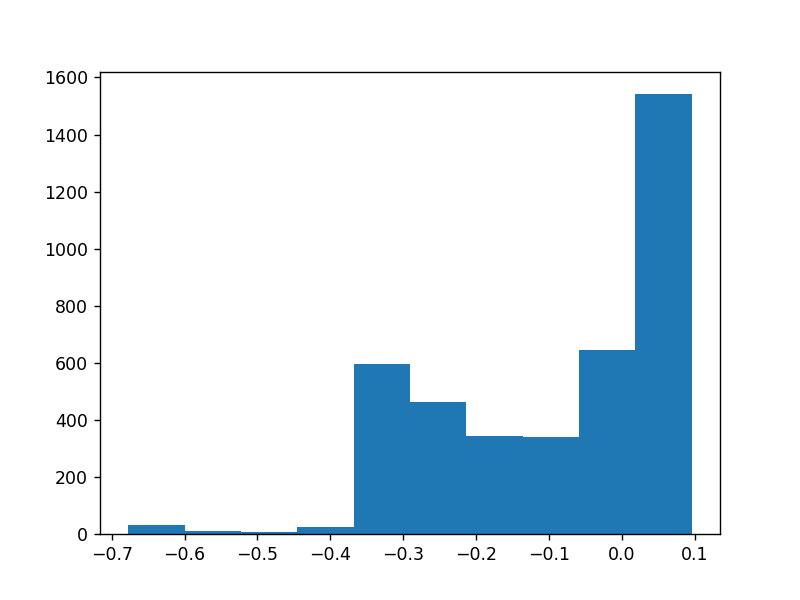

(array([   31.,    10.,     8.,    24.,   595.,   461.,   342.,   341.,
          646.,  1542.]),
 array([-0.67741404, -0.60005884, -0.52270363, -0.44534843, -0.36799323,
        -0.29063803, -0.21328283, -0.13592762, -0.05857242,  0.01878278,
         0.09613798]),
 <a list of 10 Patch objects>)

In [16]:
plt.hist(agent_rew_hist[:4000])

In [17]:
kvparams["eta"] = 0.1

act_trainer["low"] = -0.15
act_trainer["high"] = 0.2

act_trainer["random_default"] = 0.10
act_trainer["random_bad"] = 0.80
act_trainer["random_good"] = 0.15
act_trainer["random_diff"] = 0.10

In [20]:
print("\n\n".join(log_list) + "\n----\n")
res = 10
for _ in tqdm_notebook(range(10), desc="main"):
    for map_seed in map_seeds:
        kvparams["map_seed"] = map_seed
        res = mine_data(log_list, dyn_plot, agent1, act_trainer, steps=4000, **kvparams)
        if res > 4:
            break
        print("")
    if res > 4:
        break

map_seed = 3
train_rmse_before = 0.387033329, train_rmse_after = 0.045986702, 
mean_train_revard = -0.090, mean_test_reward  = -0.034,
steps = total: 4000, bad: 0.0000, good: 1.0000, diff: 0.0000, other: 0.0000,
collisions = 0.554250, circles = 0.586460

map_seed = 3
train_rmse_before = 0.093635412, train_rmse_after = 0.042610028, 
mean_train_revard = -0.077, mean_test_reward  = -0.022,
steps = total: 4000, bad: 0.4238, good: 0.0003, diff: 0.0000, other: 0.5760,
collisions = 0.485500, circles = 1.707924

map_seed = 13
train_rmse_before = 0.081097572, train_rmse_after = 0.042009883, 
mean_train_revard = -0.072, mean_test_reward  = 0.005,
steps = total: 4000, bad: 0.4385, good: 0.0020, diff: 0.0000, other: 0.5595,
collisions = 0.511250, circles = 1.634792

map_seed = 18
train_rmse_before = 0.071153834, train_rmse_after = 0.040832713, 
mean_train_revard = -0.064, mean_test_reward  = 0.011,
steps = total: 4000, bad: 0.3560, good: 0.0025, diff: 0.0000, other: 0.6415,
collisions = 0.394000, 

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 3
train_rmse_before = 0.058568327, train_rmse_after = 0.039080490, 
mean_train_revard = -0.042, mean_test_reward  = 0.030,
steps = total: 4000, bad: 0.3785, good: 0.0130, diff: 0.0000, other: 0.6085,
collisions = 0.394000, circles = 3.238052



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 13
train_rmse_before = 0.044969149, train_rmse_after = 0.039115772, 
mean_train_revard = -0.042, mean_test_reward  = 0.032,
steps = total: 4000, bad: 0.3463, good: 0.0163, diff: 0.0000, other: 0.6375,
collisions = 0.403000, circles = 2.818419



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 18
train_rmse_before = 0.044487308, train_rmse_after = 0.038727877, 
mean_train_revard = -0.041, mean_test_reward  = 0.046,
steps = total: 4000, bad: 0.3407, good: 0.0355, diff: 0.0000, other: 0.6238,
collisions = 0.373250, circles = 2.775231



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 23
train_rmse_before = 0.045815082, train_rmse_after = 0.038937253, 
mean_train_revard = -0.042, mean_test_reward  = 0.021,
steps = total: 4000, bad: 0.4255, good: 0.0130, diff: 0.0000, other: 0.5615,
collisions = 0.540000, circles = 3.217781



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 3
train_rmse_before = 0.044964147, train_rmse_after = 0.038930486, 
mean_train_revard = -0.042, mean_test_reward  = 0.028,
steps = total: 4000, bad: 0.3628, good: 0.0138, diff: 0.0000, other: 0.6235,
collisions = 0.408250, circles = 3.388438



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 13
train_rmse_before = 0.045229308, train_rmse_after = 0.039446660, 
mean_train_revard = -0.043, mean_test_reward  = 0.034,
steps = total: 4000, bad: 0.3857, good: 0.0140, diff: 0.0000, other: 0.6002,
collisions = 0.424000, circles = 2.957443



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 18
train_rmse_before = 0.046016059, train_rmse_after = 0.039424400, 
mean_train_revard = -0.042, mean_test_reward  = 0.037,
steps = total: 4000, bad: 0.3330, good: 0.0150, diff: 0.0000, other: 0.6520,
collisions = 0.367250, circles = 3.035209



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 23
train_rmse_before = 0.046870657, train_rmse_after = 0.039441663, 
mean_train_revard = -0.044, mean_test_reward  = 0.005,
steps = total: 4000, bad: 0.4125, good: 0.0160, diff: 0.0000, other: 0.5715,
collisions = 0.514750, circles = 2.648328



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 3
train_rmse_before = 0.045579040, train_rmse_after = 0.039345865, 
mean_train_revard = -0.044, mean_test_reward  = 0.034,
steps = total: 4000, bad: 0.3370, good: 0.0152, diff: 0.0000, other: 0.6478,
collisions = 0.404250, circles = 3.348996



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 13
train_rmse_before = 0.045619498, train_rmse_after = 0.039497267, 
mean_train_revard = -0.045, mean_test_reward  = 0.024,
steps = total: 4000, bad: 0.3847, good: 0.0143, diff: 0.0000, other: 0.6010,
collisions = 0.429500, circles = 2.989388



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 18
train_rmse_before = 0.044769695, train_rmse_after = 0.039660434, 
mean_train_revard = -0.044, mean_test_reward  = 0.032,
steps = total: 4000, bad: 0.3202, good: 0.0198, diff: 0.0000, other: 0.6600,
collisions = 0.370500, circles = 2.990614



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 23
train_rmse_before = 0.045283988, train_rmse_after = 0.039279251, 
mean_train_revard = -0.044, mean_test_reward  = 0.017,
steps = total: 4000, bad: 0.3322, good: 0.0140, diff: 0.0003, other: 0.6535,
collisions = 0.422500, circles = 3.141775



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 3
train_rmse_before = 0.044406224, train_rmse_after = 0.039335624, 
mean_train_revard = -0.044, mean_test_reward  = 0.030,
steps = total: 4000, bad: 0.3167, good: 0.0143, diff: 0.0000, other: 0.6690,
collisions = 0.363000, circles = 3.488424



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 13
train_rmse_before = 0.044919166, train_rmse_after = 0.039403213, 
mean_train_revard = -0.044, mean_test_reward  = 0.034,
steps = total: 4000, bad: 0.3553, good: 0.0138, diff: 0.0000, other: 0.6310,
collisions = 0.397250, circles = 2.971126



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 18
train_rmse_before = 0.044907367, train_rmse_after = 0.039151898, 
mean_train_revard = -0.043, mean_test_reward  = 0.030,
steps = total: 4000, bad: 0.3535, good: 0.0208, diff: 0.0000, other: 0.6258,
collisions = 0.390250, circles = 2.724467



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 23
train_rmse_before = 0.045576077, train_rmse_after = 0.039270085, 
mean_train_revard = -0.043, mean_test_reward  = 0.024,
steps = total: 4000, bad: 0.3648, good: 0.0120, diff: 0.0003, other: 0.6230,
collisions = 0.508000, circles = 2.926419



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 3
train_rmse_before = 0.044858289, train_rmse_after = 0.039228485, 
mean_train_revard = -0.043, mean_test_reward  = 0.017,
steps = total: 4000, bad: 0.3310, good: 0.0125, diff: 0.0000, other: 0.6565,
collisions = 0.384750, circles = 3.078563



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 13
train_rmse_before = 0.045419987, train_rmse_after = 0.039373068, 
mean_train_revard = -0.044, mean_test_reward  = 0.020,
steps = total: 4000, bad: 0.3900, good: 0.0168, diff: 0.0000, other: 0.5933,
collisions = 0.445500, circles = 3.067081



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 18
train_rmse_before = 0.043793182, train_rmse_after = 0.039338806, 
mean_train_revard = -0.044, mean_test_reward  = 0.039,
steps = total: 4000, bad: 0.3395, good: 0.0177, diff: 0.0000, other: 0.6427,
collisions = 0.372000, circles = 3.277760



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 23
train_rmse_before = 0.046736024, train_rmse_after = 0.039534373, 
mean_train_revard = -0.040, mean_test_reward  = 0.018,
steps = total: 4000, bad: 0.4180, good: 0.0118, diff: 0.0003, other: 0.5700,
collisions = 0.469250, circles = 3.221642



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 3
train_rmse_before = 0.045940911, train_rmse_after = 0.039851892, 
mean_train_revard = -0.041, mean_test_reward  = 0.031,
steps = total: 4000, bad: 0.3513, good: 0.0100, diff: 0.0000, other: 0.6387,
collisions = 0.425000, circles = 3.852857



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 13
train_rmse_before = 0.045235110, train_rmse_after = 0.039832232, 
mean_train_revard = -0.041, mean_test_reward  = 0.033,
steps = total: 4000, bad: 0.3980, good: 0.0192, diff: 0.0000, other: 0.5827,
collisions = 0.439000, circles = 2.980254



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 18
train_rmse_before = 0.044121172, train_rmse_after = 0.039455417, 
mean_train_revard = -0.040, mean_test_reward  = 0.029,
steps = total: 4000, bad: 0.3125, good: 0.0240, diff: 0.0000, other: 0.6635,
collisions = 0.371500, circles = 3.068449



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 23
train_rmse_before = 0.045850139, train_rmse_after = 0.039310850, 
mean_train_revard = -0.040, mean_test_reward  = 0.013,
steps = total: 4000, bad: 0.3830, good: 0.0170, diff: 0.0003, other: 0.5998,
collisions = 0.468000, circles = 2.906193



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 3
train_rmse_before = 0.045352651, train_rmse_after = 0.039145138, 
mean_train_revard = -0.040, mean_test_reward  = 0.026,
steps = total: 4000, bad: 0.3785, good: 0.0120, diff: 0.0000, other: 0.6095,
collisions = 0.424500, circles = 3.544172



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 13
train_rmse_before = 0.045599229, train_rmse_after = 0.039599704, 
mean_train_revard = -0.042, mean_test_reward  = 0.024,
steps = total: 4000, bad: 0.4405, good: 0.0147, diff: 0.0000, other: 0.5448,
collisions = 0.497250, circles = 2.975724



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 18
train_rmse_before = 0.043735422, train_rmse_after = 0.038840892, 
mean_train_revard = -0.041, mean_test_reward  = 0.023,
steps = total: 4000, bad: 0.3435, good: 0.0165, diff: 0.0000, other: 0.6400,
collisions = 0.379500, circles = 2.777540



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 23
train_rmse_before = 0.047982407, train_rmse_after = 0.039155590, 
mean_train_revard = -0.042, mean_test_reward  = 0.012,
steps = total: 4000, bad: 0.4363, good: 0.0067, diff: 0.0000, other: 0.5570,
collisions = 0.589250, circles = 3.214895



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 3
train_rmse_before = 0.045878795, train_rmse_after = 0.039329336, 
mean_train_revard = -0.043, mean_test_reward  = 0.024,
steps = total: 4000, bad: 0.3920, good: 0.0097, diff: 0.0000, other: 0.5982,
collisions = 0.420750, circles = 3.779760



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 13
train_rmse_before = 0.045998098, train_rmse_after = 0.039349306, 
mean_train_revard = -0.043, mean_test_reward  = 0.014,
steps = total: 4000, bad: 0.3950, good: 0.0290, diff: 0.0000, other: 0.5760,
collisions = 0.447250, circles = 2.722319



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 18
train_rmse_before = 0.045109625, train_rmse_after = 0.039745226, 
mean_train_revard = -0.044, mean_test_reward  = 0.020,
steps = total: 4000, bad: 0.3720, good: 0.0320, diff: 0.0000, other: 0.5960,
collisions = 0.400250, circles = 3.033243



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 23
train_rmse_before = 0.047238209, train_rmse_after = 0.039749338, 
mean_train_revard = -0.045, mean_test_reward  = 0.009,
steps = total: 4000, bad: 0.4045, good: 0.0125, diff: 0.0000, other: 0.5830,
collisions = 0.518500, circles = 2.902078



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 3
train_rmse_before = 0.046905318, train_rmse_after = 0.039983044, 
mean_train_revard = -0.046, mean_test_reward  = 0.030,
steps = total: 4000, bad: 0.3680, good: 0.0100, diff: 0.0000, other: 0.6220,
collisions = 0.413750, circles = 3.763950



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 13
train_rmse_before = 0.046015557, train_rmse_after = 0.040117596, 
mean_train_revard = -0.045, mean_test_reward  = 0.024,
steps = total: 4000, bad: 0.3450, good: 0.0232, diff: 0.0000, other: 0.6318,
collisions = 0.397500, circles = 3.046504



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 18
train_rmse_before = 0.045483300, train_rmse_after = 0.039962972, 
mean_train_revard = -0.045, mean_test_reward  = 0.023,
steps = total: 4000, bad: 0.3395, good: 0.0127, diff: 0.0000, other: 0.6478,
collisions = 0.382000, circles = 2.617249



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 23
train_rmse_before = 0.046857983, train_rmse_after = 0.040077881, 
mean_train_revard = -0.046, mean_test_reward  = 0.011,
steps = total: 4000, bad: 0.4093, good: 0.0123, diff: 0.0000, other: 0.5785,
collisions = 0.488000, circles = 3.200101



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 3
train_rmse_before = 0.046685407, train_rmse_after = 0.040196026, 
mean_train_revard = -0.046, mean_test_reward  = 0.018,
steps = total: 4000, bad: 0.3745, good: 0.0107, diff: 0.0000, other: 0.6148,
collisions = 0.424750, circles = 3.045714



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 13
train_rmse_before = 0.046450589, train_rmse_after = 0.040403168, 
mean_train_revard = -0.046, mean_test_reward  = 0.004,
steps = total: 4000, bad: 0.3465, good: 0.0170, diff: 0.0000, other: 0.6365,
collisions = 0.381250, circles = 2.721463



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 18
train_rmse_before = 0.044510560, train_rmse_after = 0.040330810, 
mean_train_revard = -0.045, mean_test_reward  = 0.025,
steps = total: 4000, bad: 0.3240, good: 0.0225, diff: 0.0000, other: 0.6535,
collisions = 0.364750, circles = 3.272719



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 23
train_rmse_before = 0.047340521, train_rmse_after = 0.040101834, 
mean_train_revard = -0.046, mean_test_reward  = 0.019,
steps = total: 4000, bad: 0.3947, good: 0.0080, diff: 0.0000, other: 0.5973,
collisions = 0.485250, circles = 3.218706




In [19]:
agent1.to_file("nn_4с.txt")

In [ ]:
import pickle

In [ ]:
agent1.to_file("nn_trained_on_50k.txt")

In [ ]:
agent1.neural_net = None

In [ ]:
pickle.dump(agent1, open("agent1.pickle", "wb"))

In [ ]:
agent1 = pickle.load(open("agent1.pickle", "rb"))

In [ ]:
agent1.neural_net = agent1.from_file("nn_trained_on_50k.txt").neural_net

# Смотрим вживую

In [21]:
def visualize(agent, map_seed):
    w = create_map(seed=map_seed, agent=agent)
    eval_res = w.evaluate_agent(agent, steps=1200, visual=True)
    eval_circle = w.circles[agent]
    print(f"visualize on map = {map_seed}, eval_res = {eval_res:4f}, eval_circle = {eval_circle:4f}")

In [22]:
for map_seed in map_seeds:
    visualize(agent1, map_seed)

visualize on map = 3, eval_res = -0.014350, eval_circle = 3.725428
visualize on map = 13, eval_res = -0.304386, eval_circle = 0.569680
visualize on map = 18, eval_res = 0.022033, eval_circle = 0.924339
visualize on map = 23, eval_res = -0.002193, eval_circle = 2.013241


# Отладка

In [ ]:
raise Exception("Здесь отладка")

In [21]:
agent_dbg = agent1

agent_dbg.clear_history()
#mine data
w = create_map(seed=map_seed, agent=agent_dbg)
w.run(steps=tqdm_notebook(range(10000), desc="train", leave=False), visual=False, save=False)

In [22]:
# prepare train data
X_train = np.concatenate([agent_dbg.sensor_data_history, agent_dbg.chosen_actions_history], axis=1)
y_train = np.array(agent_dbg.reward_history)
mean_train_revard = y_train.mean()
y_train = norm_y(y_train)
y_clean = y_train.copy()

mean_train_revard

-0.12005822168687524

In [23]:
reward_shift = kvparams["reward_shift"]
alpha = kvparams["alpha"]

In [24]:
y_train = np.pad(y_train, (0, 2 * reward_shift), mode="constant")
y_train = reduce(lambda a, b: a + b, [y_train[i:(-2 * reward_shift + i)] * (alpha ** i)
                                      for i in range(reward_shift)])

In [25]:
y_predict = agent_dbg.neural_net.feedforward(X_train.T)

In [26]:
pd_visual = pd.DataFrame(X_train,
                         columns=["velocity", "angle"] +
                         ["lid{}".format(i) for i in range(agent_dbg.rays)] +
                         ["steering", "acceleration"])
pd_visual["y_clean"] = y_clean
pd_visual["y_train"] = y_train
pd_visual["y_predict"] = y_predict.flatten()

## Смотрим на входные данные

In [ ]:
from functools import reduce

In [ ]:
pd_visual.loc[:4000]

In [ ]:
pd_visual.steering.hist(bins=3)

In [ ]:
pd_visual.acceleration.hist(bins=3)

In [ ]:
pd_visual[reduce(lambda a, b: a | b, [(pd_visual.y_clean < 0).shift(-i) for i in range(reward_shift+2)])].iloc[4000:]

In [ ]:
plt.ion()

In [ ]:
pd_visual["lid2"].hist(bins=np.arange(0,5,0.1))

In [ ]:
pd_visual[reduce(lambda a, b: a | b, [(pd_visual.y_clean < 0).shift(-i) for i in range(5, 10)])] \
    ["lid2"].hist(bins=np.arange(0,5,0.1))

## Смотрим как сеть реагирует на входные данные

In [ ]:
(pd_visual.y_clean[200:] < 0).argmax()

In [ ]:
pd_visual.loc[265:285]

In [ ]:
from cars.utils import Action

In [ ]:
sensor_info = pd_visual.loc[273].values[:7]
rewards_to_controls_map = []
# дискретизируем множество значений, так как все возможные мы точно предсказать не сможем
for steering in np.linspace(-1, 1, 3):  # выбирать можно и другую частоту дискретизации, но
    for acceleration in np.linspace(-0.75, 0.75, 3):  # в наших тестах будет именно такая
        action = Action(steering, acceleration)
        agent_vector_representation = np.append(sensor_info, action)
        agent_vector_representation = agent_vector_representation.flatten()[:, np.newaxis]
        predicted_reward = float(agent_dbg.neural_net.feedforward(agent_vector_representation))
        rewards_to_controls_map.append((predicted_reward, action))

rewards_to_controls_map

In [ ]:
sorted(rewards_to_controls_map, key=lambda x: x[0])[-1]

In [ ]:
sensor_info = pd_visual.loc[275].values[:7]
rewards_to_controls_map = []
# дискретизируем множество значений, так как все возможные мы точно предсказать не сможем
for steering in np.linspace(-1, 1, 3):  # выбирать можно и другую частоту дискретизации, но
    for acceleration in np.linspace(-0.75, 0.75, 3):  # в наших тестах будет именно такая
        action = Action(steering, acceleration)
        agent_vector_representation = np.append(sensor_info, action)
        agent_vector_representation = agent_vector_representation.flatten()[:, np.newaxis]
        predicted_reward = float(agent_dbg.neural_net.feedforward(agent_vector_representation))
        rewards_to_controls_map.append((predicted_reward, action))

rewards_to_controls_map

In [ ]:
sorted(rewards_to_controls_map, key=lambda x: x[0])[-1]

In [ ]:
pd_visual[-8000:-6000].plot(y=["y_clean", "y_train", "y_predict"], figsize=(64, 4))

In [ ]:
rmse_before = ((pd_visual.y_train - pd_visual.y_predict)**2).mean() ** 0.5
rmse_before

# Смотрим как сеть учится

In [31]:
kvparams

{'alpha': 0.7,
 'clear_history': False,
 'epochs': 100,
 'eta': 0.1,
 'map_seed': 18,
 'mini_batch_size': 50,
 'reward_shift': 3}

In [34]:
plt.ion()

In [28]:
train_data = [(x[:, np.newaxis], y) for x, y in zip(X_train, y_train)]

In [92]:
from learning_algorithms.network import Network
agent_dbg.neural_net = Network([9, 36, 20, 20, 10, 1], output_function=lambda x: x, output_derivative=lambda x: 1)

In [93]:
epoch_num = 1
dyp_x = []
dyp_y = []

<IPython.core.display.Javascript object>


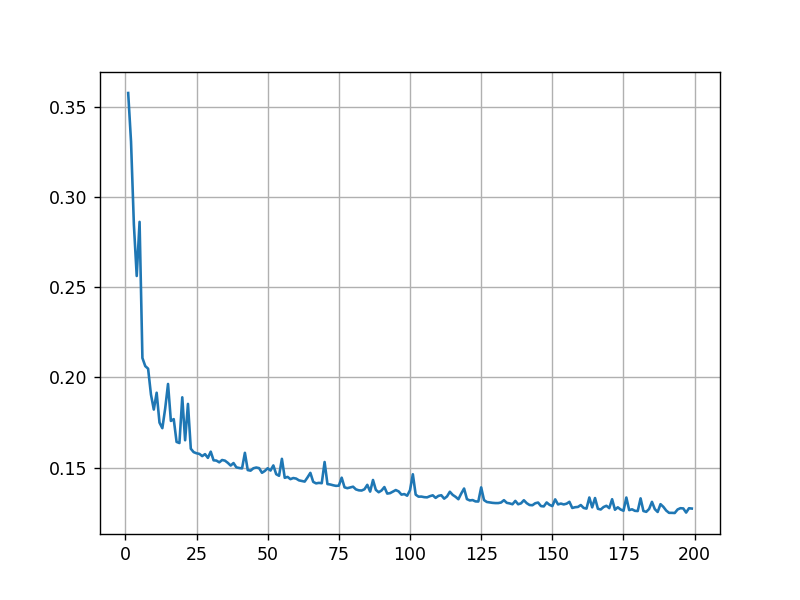

min rmse: 0.124154183800949


In [94]:
plt.ion()
dyp = DynamicUpdate()
dyp.on_launch()

try:
    for res in agent_dbg.neural_net.SGD(
            training_data=train_data,
            epochs=800, mini_batch_size=200, eta=0.4,
            test_data=(X_train.T, y_train)):
        dyp_x.append(epoch_num)
        epoch_num += 1
        dyp_y.append(res)
        if epoch_num % 10 == 0:
            dyp.on_running(dyp_x, dyp_y)
except KeyboardInterrupt:
    print("min rmse: {}".format(min(dyp_y)))

In [88]:
print("- min rmse: {:4f} for {}".format(min(dyp_y), agent_dbg.neural_net.sizes))

- min rmse: 0.077144 for [9, 36, 20, 20, 10, 1]


- min rmse: 0.096779 for [9, 18, 8, 1], epochs=500, mini_batch_size=50, eta=0.5
- min rmse: 0.097438 for [9, 18, 5, 5, 1], epochs=500, mini_batch_size=50, eta=0.5
- min rmse: 0.095456 for [9, 18, 5, 5, 5, 1], epochs=500, mini_batch_size=50, eta=0.5
- min rmse: 0.088339 for [9, 36, 10, 10, 10, 1], epochs=500, mini_batch_size=50, eta=0.5
- min rmse: 0.089725 for [9, 36, 20, 20, 10, 1], epochs=800, mini_batch_size=80, eta=0.7
- min rmse: 0.077144 for [9, 36, 20, 20, 10, 1], epochs=800, mini_batch_size=20, eta=1.4

## Сравним

In [44]:
rfcls = RandomForestWrapper(n_jobs=50)

In [45]:
next(rfcls.SGD(
    training_data=train_data,
    epochs=500,
    mini_batch_size=50,
    eta=0.1))

In [46]:
rfcls.evaluate(X_train.T, y_train)

0.039722006904538754